## data preprocess
### data cleaning on quality issues
For each feature identify the following problems
* Inconsistent values
* Duplicate records
Duplicate should be removed immediately from database/dataset
* Missing values
* Invalid values
* Outliers

### data transformation
scaling, transformation, feature selection, dim reduction, data manipulation
* scaling - normalization
* transformation - category vectorize
* feature selection/engineering

In [10]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views(materialize=True)

### county_properties, property_features, property_addresses
* restrict properties to land_use_code = 1, land_use_subcode: [11, 17]  ~ 711255
* year_built has 2 digit, it's not clear if it's 19xx or 20xx, eg '10' could be 1910 or 2010
* 1784 properties have sqft = 0
* 146 properties missed address
* final valid: 709325

### county_addresses
* Among 709325 valid properties, 673826(95%) have addresses encoded as geo lon/lat with rank > 20

### county_transactions ###
* (duplicate) records in transactions: can be identified by (pin, trailer_pin, doc_date)?
* Lots of transactions with code 'M' seem to have weird sold_price value?
* (invalid values) 174764 transactions have price = 0, they all appear after 2009-01-01
* (outlier or invalid?) weird values: sqft > 1000ft and sold_price < 50000 in year 2017, eg Borrego Springs
* (missing records) some transactions that we knew didn't exist in data

* valid transactions: 1449003


In [13]:
# all transactions
df_all = ds.get_view_df('property_address_transactions')
print(df_all.shape)
df_all[:3]

(1512560, 23)


,pin,land_use_subcode,year_built,sqft,usable_sqft,acre,num_bed,num_bath,pool,view,...,street,st_type,unit_no,city,zip,lon,lat,sold_price,date,sqft_price
0,5754330300,11,1955.0,1120,7700.0,0,3.0,1.0,N,N,...,HILLTOP,DR,None,CHULA VISTA,91911,-117.05661,32.61670,447000,2017-10-24,399
1,1657014212,17,1993.0,1016,NaN,0,2.0,2.0,None,None,...,GENOA,WAY,90,OCEANSIDE,92056,-117.30922,33.18833,397000,2017-10-19,390
2,4370430100,12,1942.0,1500,13600.0,0,4.0,2.0,N,N,...,BURTON,ST,None,SAN DIEGO,92111,-117.17271,32.77414,0,2017-10-03,0


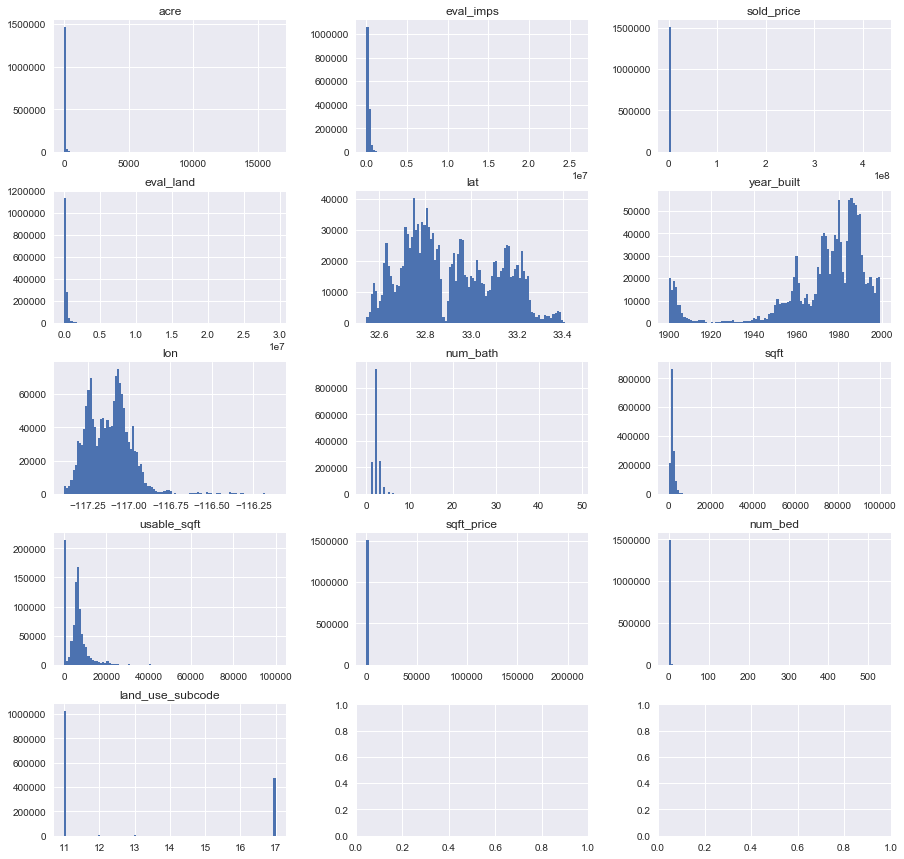

In [14]:
# check various feature distribution
columns = set(df_all.columns) - set(['pin'])
plot_feature_histogram(df_all, list(columns))

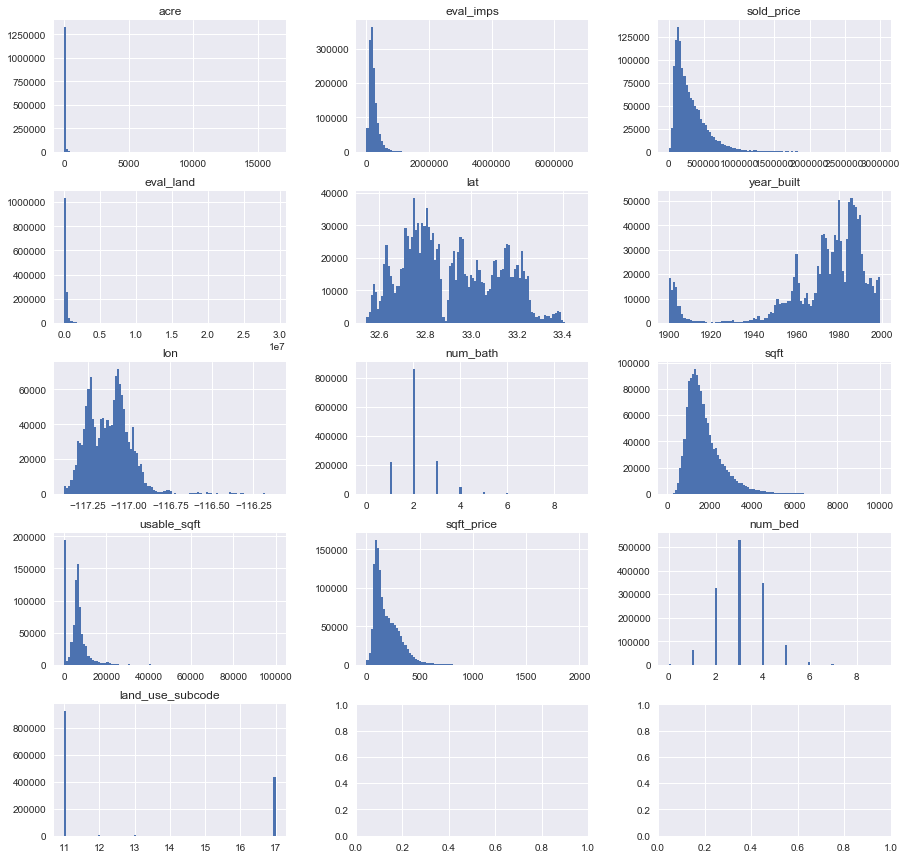

In [16]:
df_all_valid = df_all[(df_all['sqft_price']<2000) &(df_all['sqft_price']>0)
                     &(df_all['sqft']<10000)
                     &(df_all['sold_price']>0) 
                     &(df_all['sold_price'] < 3000000)
                     &(df_all['num_bed']<10)
                     &(df_all['num_bath']<10)
                     &(df_all['lon'].notnull())
                     ]
plot_feature_histogram(df_all_valid, list(columns))

In [17]:
print(df_all.shape)
print(df_all_valid.shape)

(1512560, 23)
(1369868, 23)


{'total': 1512560, 'sold_price': 1445753, 'sqft_price': 1448693, 'sqft': 1511550, 'num_bath': 1512009, 'num_bed': 1511762, 'lon': 1434716}


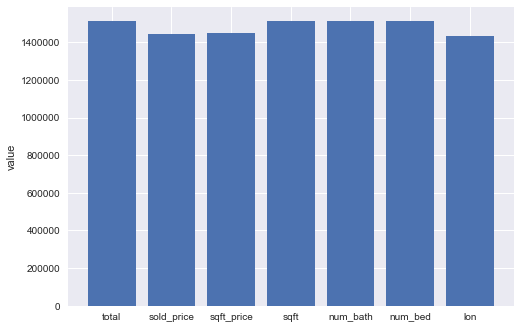

In [18]:
# check valid data size for each valid condition
pp = Preprocess(df_all)
valid_counts = pp.get_valid_count()
print(valid_counts)
plot_bar(valid_counts)

In [19]:
# check the preprocess module set correct condition for valid range
df_all_valid1 = pp.dataset(feature='delivered', valid=True)
print(df_all_valid.shape[0])
print(df_all_valid1.shape[0])

[dp] feature 'prop_count_zip' is missing due to preprocess doesn't have df_property


1369868
1369868


In [20]:
# last year transactions 
df_last_year = df_all[(pd.to_datetime(df_all['date']) >= '2016-10-01') & (pd.to_datetime(df_all['date']) < '2017-10-01')]
df_last_year.shape

(41100, 23)

In [21]:
df_last_year[df_last_year['sold_price']==0].shape

(3162, 23)

In [22]:
df_last_year[df_last_year['sold_price']==0][:10]

,pin,land_use_subcode,year_built,sqft,usable_sqft,acre,num_bed,num_bath,pool,view,...,street,st_type,unit_no,city,zip,lon,lat,sold_price,date,sqft_price
5,4993631100,11,1959.0,1770,5000.0,0,3.0,2.0,N,Y,...,KENWOOD,DR,None,SPRING VALLEY,91977,-117.00757,32.74664,0,2017-09-27,0
9,5561805536,17,1996.0,378,0.0,0,1.0,1.0,None,N,...,J,AVE,64,NATIONAL CITY,91950,-117.09840,32.68284,0,2017-09-27,0
73,1876510400,11,1994.0,2462,0.0,0,5.0,3.0,N,Y,...,SUMMIT CIRCLE,GLN,None,ESCONDIDO,92026,NaN,NaN,0,2017-09-27,0
172,1613431500,11,1979.0,873,NaN,0,2.0,1.0,N,None,...,HIGHRIDGE,DR,None,OCEANSIDE,92056,-117.27259,33.22056,0,2017-09-26,0
209,1866124400,11,1992.0,4822,0.0,209,5.0,4.0,Y,Y,...,HIGH VISTA,DR,None,ESCONDIDO,92026,-117.12176,33.20697,0,2017-09-25,0
305,3194015300,11,1987.0,1937,0.0,0,3.0,2.0,N,Y,...,MIRA LAGO,WAY,None,SAN DIEGO,92131,-117.08535,32.91920,0,2017-09-25,0
323,1668100400,17,1994.0,1824,NaN,0,3.0,2.0,None,N,...,JANIS LYNN,LN,None,VISTA,92083,-117.27137,33.19459,0,2017-09-25,0
332,6720202700,11,1956.0,1242,6400.0,0,4.0,2.0,N,N,...,IRWIN,AVE,None,SAN DIEGO,92120,-117.07891,32.79881,0,2017-09-25,0
338,5913312600,11,1985.0,1865,5000.0,0,4.0,2.0,N,N,...,PARKSIDE,PL,None,SAN DIEGO,92139,-117.05049,32.66769,0,2017-09-25,0
345,4893802913,17,1982.0,1232,NaN,0,2.0,2.0,None,N,...,DECKER,ST,B,EL CAJON,92019,-116.94343,32.79370,0,2017-09-25,0


{'total': 41100, 'sold_price': 37659, 'sqft_price': 37918, 'sqft': 41081, 'num_bath': 41088, 'num_bed': 41079, 'lon': 37358}


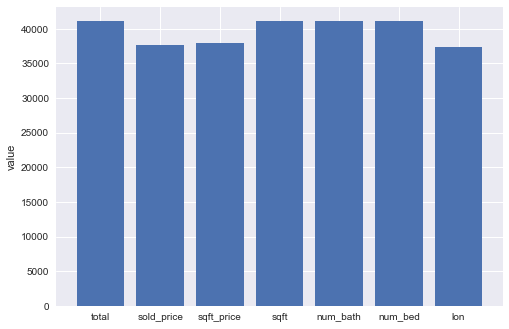

In [23]:
pp_last_year = Preprocess(df_last_year)
valid_counts = pp_last_year.get_valid_count()
print(valid_counts)
plot_bar(valid_counts)

In [24]:
df_last_year_valid = pp_last_year.dataset(feature='delivered', valid=True)
print(df_last_year_valid.shape[0])

[dp] feature 'prop_count_zip' is missing due to preprocess doesn't have df_property


34192
